In [1]:
% run qpfs_class_draft.ipynb

In [2]:
% run Analysys\ Draft.ipynb

<function condition_number_xtx at 0x7f1892518268>
[ 1.  0.  0.  0.  1.]
{'Det Coef': 2, 'Adj Det Coef': 1, 'RSS': 0, 'BIC': 4, "Mallow's Cp": 5, 'VIF': 3}


In [3]:
class Selector():
    def __init__(self, algo):
        self.algo = algo
    def fit(self, X, y):
        self.algo.fit(X, y)
    def select(self, num_features):
        return self.algo.select(num_features)

In [454]:

import matplotlib.pyplot as plt
%matplotlib inline

class ModelQuality():
    def __init__(self, selector, model):
        self.model = model
        self.selector = selector
    def fit(self, X, y, ns_features=None, test_size=0.3, X_test=None, y_test=None):
        if ns_features is None:
            ns_features = np.arange(X.shape[1]) + 1
            #print(ns_features)
        else:
            ns_features = np.sort(np.array(ns_features))
        self.ns_features = ns_features
        if X_test is None:
            from sklearn.model_selection import train_test_split
            self.X_train, self.X_test, self.y_train, self.y_test = \
                train_test_split(X, y, test_size=test_size, random_state=179)
        else:
            self.X_train = X
            self.y_train = y
            self.X_test = X_test
            self.y_test = y_test

        self.masks = np.zeros((len(ns_features), X.shape[1]), dtype=np.bool)
        self.selector.fit(self.X_train, self.y_train)
        for (i, num) in enumerate(ns_features):
            cur_features = self.selector.select(num)
            self.masks[i][cur_features] = True

    def evaluate(self, metrics = [], comparisons = [], characteristics = [], n_samples=20, mode='static'):
        if mode == 'static':
            self.evaluate_info = EvaluateStaticInfo(self.model, metrics, comparisons)
        else:
            self.evaluate_info = EvaluateDynamicInfo(self.model, metrics, comparisons, characteristics)
        #print(self.X_train)
        #print(self.y_train)
        print(self.evaluate_info)
        self.n_samples = n_samples
        self.evaluate_info.fit(self.X_train, self.y_train, self.X_test, self.y_test, self.masks, n_samples)
        self.result = self.evaluate_info.get_result()
        self.quality = self.evaluate_info.get_quality()
    
    def calc_mean_and_std(self):
        self.mean = np.mean(self.result, axis=-1)
        self.std = np.std(self.result, axis=-1)
    
    def _draw_all(self, names, func):
        if names is None:
            names = list(self.evaluate_info.names.keys())
        rows = (len(names)+2) // 2
        plt.figure(figsize=(20, 6 * rows))
        for i in range(len(names)):
            plt.subplot(rows, 2, i+1)
            plt.scatter(self.ns_features, np.zeros_like(self.ns_features), label='used n', alpha=0.3, color='red')
            name = names[i]
            func(name)
            plt.legend()
            plt.title(name)
            plt.xlabel('n')
        plt.show()
        
    def _get_index_by_name(self, name):
        return self.evaluate_info.names[name]
        
    def _draw_one(self, name):
        index = self._get_index_by_name(name)
        plt.plot(self.ns_features, self.quality[index], label='quality')
        plt.plot(self.ns_features, self.mean[index], label='mean')
        #plt.plot(self.ns_features, self.mean[index] + self.std[index], color='navy', label='mean+-std')
        plt.fill_between(self.ns_features, self.mean[index] - self.std[index], self.mean[index] + self.std[index],
                         alpha=0.2, label='std', color='blue')
        for i in range(self.n_samples):
            plt.plot(self.ns_features, self.result[index, :, i], color='purple', alpha=0.2)
        plt.ylabel(name)
        
    def draw(self, names=None):
        self._draw_all(names, self._draw_one)
    
    def _draw_std_one(self, name):
        index = self._get_index_by_name(name)
        plt.plot(self.ns_features, self.std[index], color='navy')
        plt.ylabel('std')
    
    def draw_std(self, names=None):
        self._draw_all(names, self._draw_std_one)
    
    def check_normality(self, pandas=False, criterion=None, alpha=0.05, return_original_p=False):
        from statsmodels.sandbox.stats.multicomp import multipletests
        if pandas:
            import pandas as pd
        if criterion is None:
            criterion = sps.normaltest
        p_val = np.zeros((len(self.result), self.result.shape[1]))
        for index in range(len(self.result)):
            for ni in range(self.result.shape[1]):
                sample = self.result[index, ni, :]
                p_val[index][ni] = criterion(sample)[1]
        res = multipletests(p_val.ravel(), method='holm')
        norm = (res[0]).reshape(p_val.shape).T
        corrected_p = (res[1]).reshape(p_val.shape).T
        p_val = p_val.T
        if pandas:
            norm = pd.DataFrame(norm, index=self.ns_features, columns=self.evaluate_info.names)
            corrected_p = pd.DataFrame(corrected_p, index=self.ns_features, 
                                            columns=self.evaluate_info.names)
            if return_original_p:
                p_val = pd.DataFrame(p_val, index=self.ns_features, columns=self.evaluate_info.names)
        if return_original_p:
            return norm, corrected_p, p_val
        else:
            return norm, corrected_p
    
    def _kullback_leibler(self, a1, s1, a2, s2):
        if s1 == 0 or s2 == 0:
            print("Error: std=0")
            return 0
        return np.log(s2/s1) + (s1**2 + (a1 - a2)**2) / (2 * s2**2) - 1/2
    
    def _draw_KL_one(self, name):
        index = self._get_index_by_name(name)
        KL = np.zeros(len(self.ns_features))
        for i in range(1, len(self.ns_features)):
            diff = self._kullback_leibler(self.mean[index][i-1], self.std[index][i-1], 
                                          self.mean[index][i], self.std[index][i])
            KL[i] = KL[i-1] + diff
        plt.plot(self.ns_features, KL, label='accumulated KL divergence')
        plt.ylabel('KL')
        
    def draw_KL(self, names=None):
        self._draw_all(names, self._draw_KL_one)
        
        
            

In [455]:
s = Selector(QPFS())
lin = LinearRegression()

In [456]:
q = ModelQuality(s, lin)

In [457]:
import scipy.stats as sps

XX = sps.norm.rvs(size=(100, 5))
X2 = sps.norm.rvs(size=(10, 5))
zz = sps.uniform.rvs(size=(5, 3))
yy = XX @ zz + sps.norm.rvs(scale=0.1, size=(100, 3))
y2 = X2 @ zz + sps.norm.rvs(scale=0.1, size=(10, 3))
maskk = np.ones(XX.shape[1])
maskk[2]=0
maskk[1] = 0
maskk[3] = 0
print(maskk)

metric1 = RSS()
metric2 = Adjusted_Determination_Coefficient()
metric3 = Determination_Coefficient()
metric4 = VIF()
metric5 = BIC()
char1 = Condition_Number()
comp1 = Cp()

[ 1.  0.  0.  0.  1.]


In [458]:
q.fit(XX, yy, ns_features = [1, 2, 4])

In [459]:
q.evaluate([metric1, metric2, metric3, metric4, metric5],
                           [comp1], [char1], mode='dynamic')

{'Det Coef': 2, 'Adj Det Coef': 1, 'Cond number': 6, 'RSS': 0, 'BIC': 4, "Mallow's Cp": 5, 'VIF': 3}


In [460]:
q.calc_mean_and_std()
q.evaluate_info.names

{'Adj Det Coef': 1,
 'BIC': 4,
 'Cond number': 6,
 'Det Coef': 2,
 "Mallow's Cp": 5,
 'RSS': 0,
 'VIF': 3}

In [461]:
q.mean.shape

(7, 3)

In [462]:
q.result.shape

(7, 3, 20)

In [463]:
q.std.shape

(7, 3)

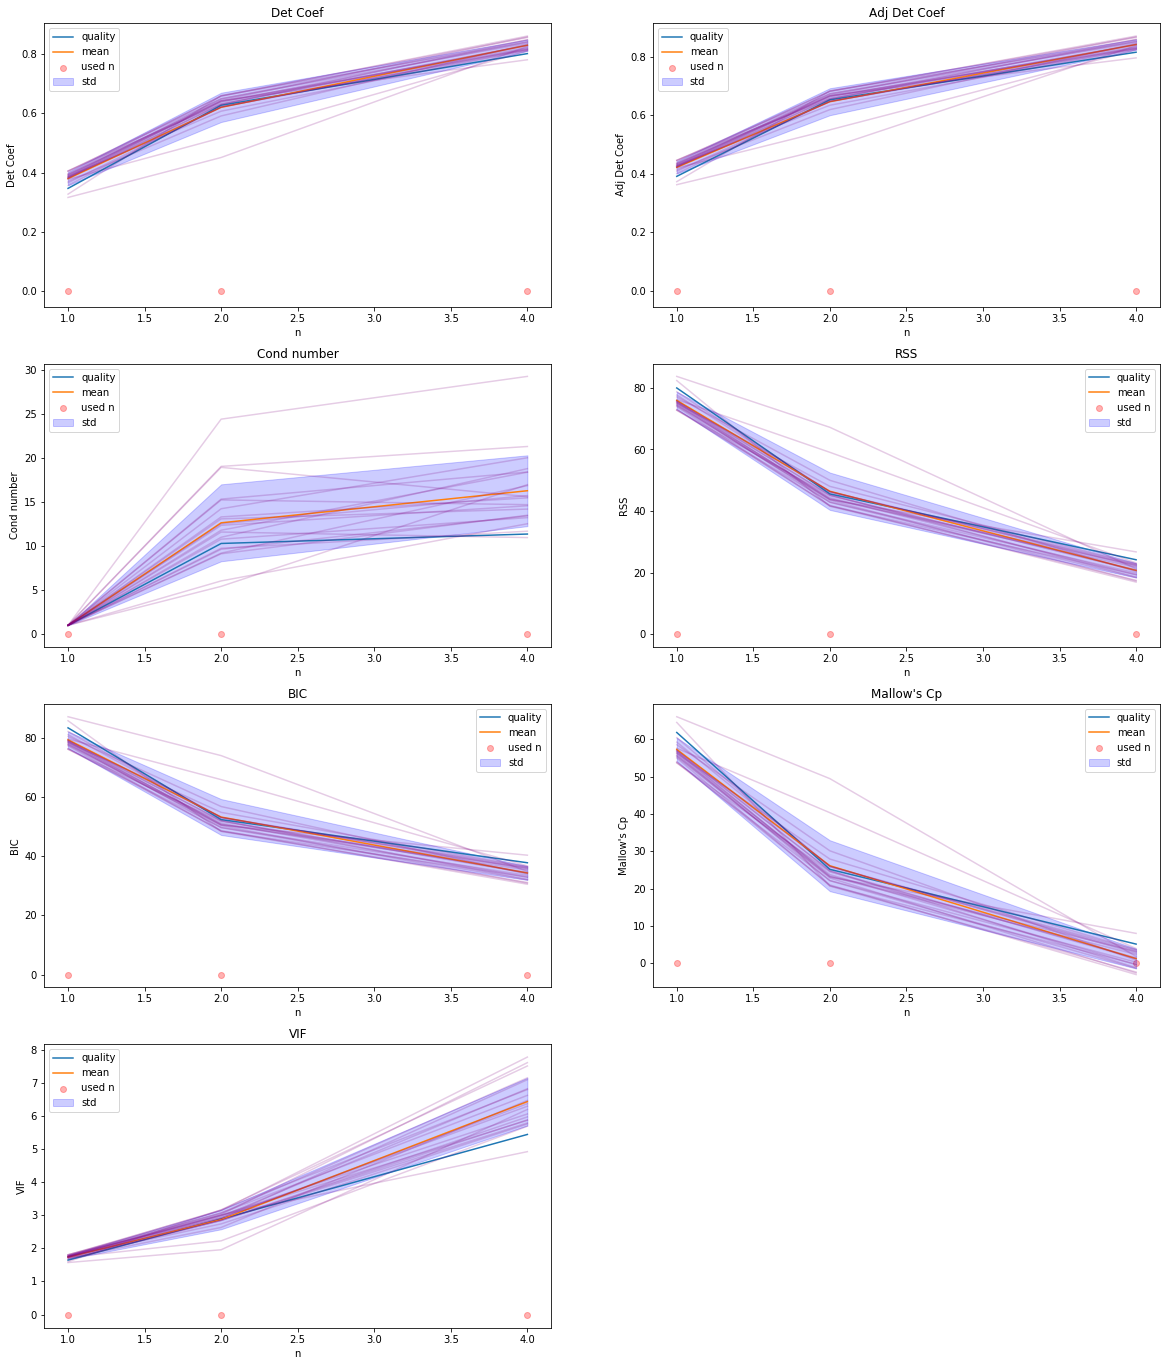

In [464]:
q.draw()

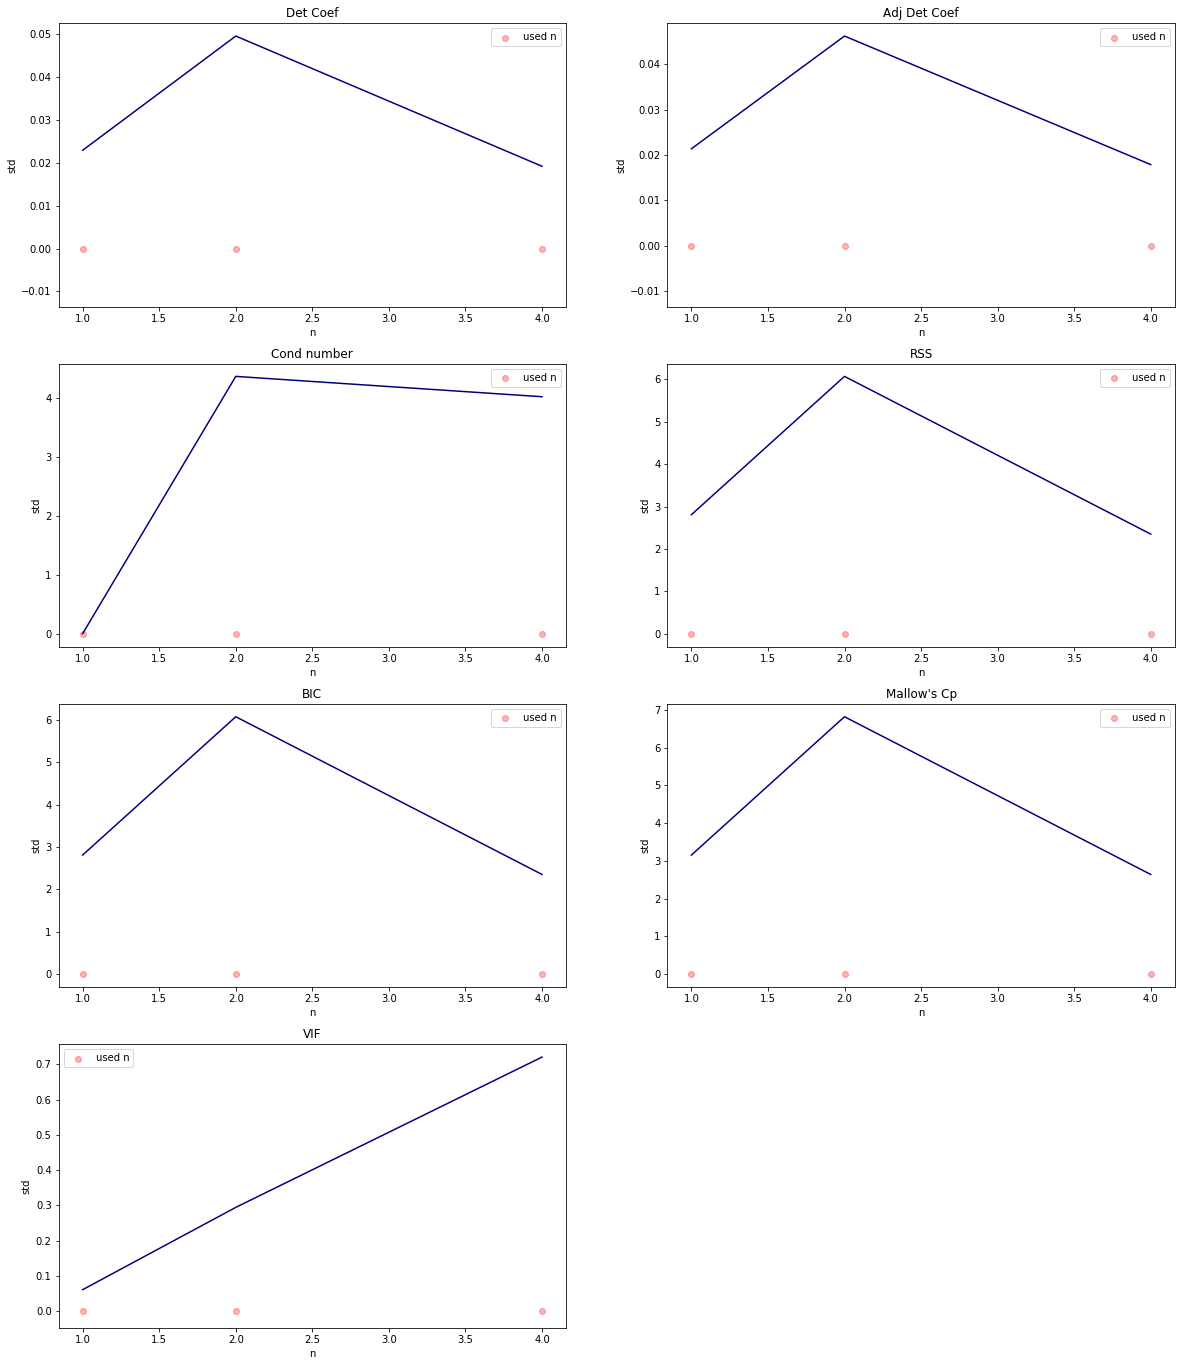

In [465]:
q.draw_std()#['Adj Det Coef','BIC', 'Det Coef', "Mallow's Cp",'RSS', 'VIF', 'Cond number'])

In [466]:
a, b, c = q.check_normality(pandas=True, return_original_p=True)

In [467]:
a

,Det Coef,Adj Det Coef,Cond number,RSS,BIC,Mallow's Cp,VIF
1,True,True,True,False,True,True,False
2,True,True,True,True,True,True,False
4,False,False,False,False,False,False,True


In [468]:
b

,Det Coef,Adj Det Coef,Cond number,RSS,BIC,Mallow's Cp,VIF
1,0.034870,0.034870,0.034870,0.069422,0.034870,0.034870,1.000000
2,0.000048,0.000048,0.000048,0.001813,0.000048,0.000048,0.671121
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.006938


In [469]:
c

,Det Coef,Adj Det Coef,Cond number,RSS,BIC,Mallow's Cp,VIF
1,0.002491,0.002491,0.002491,0.007714,0.002491,0.002491,0.582071
2,0.000002,0.000002,0.000002,0.000113,0.000002,0.000002,0.083890
4,0.497445,0.497445,0.497445,0.925870,0.497445,0.497445,0.000463


Error: std=0


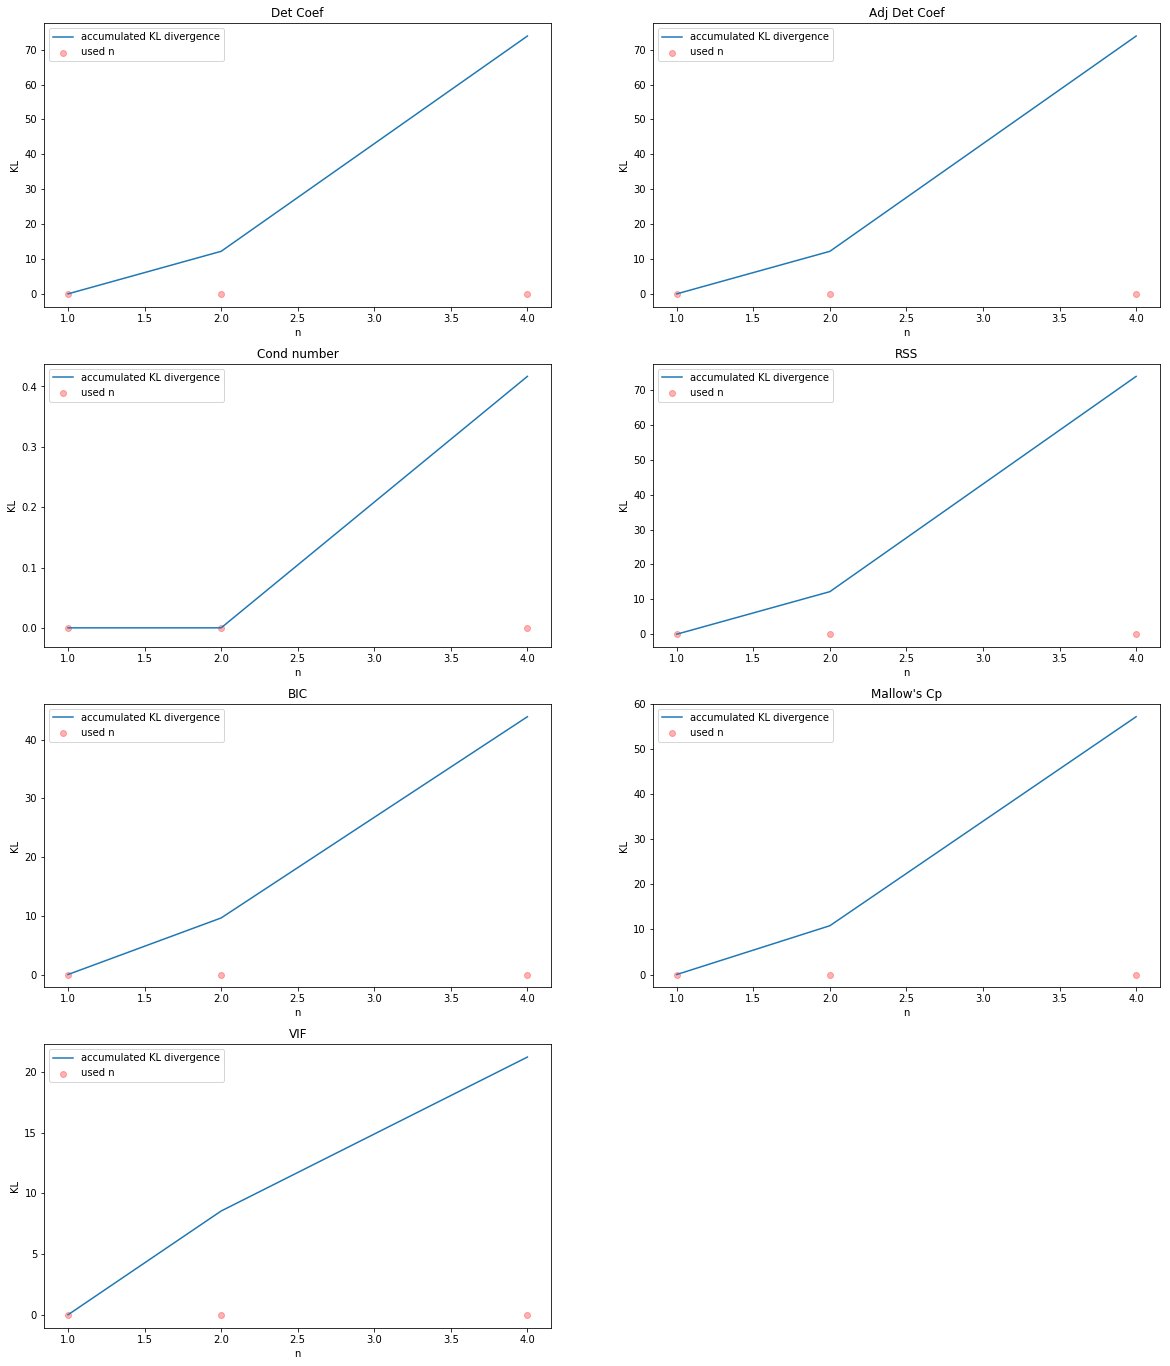

In [470]:
q.draw_KL()